In [1]:
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
import shap

import sys
sys.path.append('../')
import utils
import os
dp = os.environ.get('pub_data')
data = dp + 'XAI/'

In [2]:
# Load dataset and add squared term
credit_score = pd.read_csv(data + 'credit_score.csv')
credit_score.columns

Index(['CUST_ID', 'INCOME', 'SAVINGS', 'DEBT', 'R_SAVINGS_INCOME',
       'R_DEBT_INCOME', 'R_DEBT_SAVINGS', 'T_CLOTHING_12', 'T_CLOTHING_6',
       'R_CLOTHING', 'R_CLOTHING_INCOME', 'R_CLOTHING_SAVINGS',
       'R_CLOTHING_DEBT', 'T_EDUCATION_12', 'T_EDUCATION_6', 'R_EDUCATION',
       'R_EDUCATION_INCOME', 'R_EDUCATION_SAVINGS', 'R_EDUCATION_DEBT',
       'T_ENTERTAINMENT_12', 'T_ENTERTAINMENT_6', 'R_ENTERTAINMENT',
       'R_ENTERTAINMENT_INCOME', 'R_ENTERTAINMENT_SAVINGS',
       'R_ENTERTAINMENT_DEBT', 'T_FINES_12', 'T_FINES_6', 'R_FINES',
       'R_FINES_INCOME', 'R_FINES_SAVINGS', 'R_FINES_DEBT', 'T_GAMBLING_12',
       'T_GAMBLING_6', 'R_GAMBLING', 'R_GAMBLING_INCOME', 'R_GAMBLING_SAVINGS',
       'R_GAMBLING_DEBT', 'T_GROCERIES_12', 'T_GROCERIES_6', 'R_GROCERIES',
       'R_GROCERIES_INCOME', 'R_GROCERIES_SAVINGS', 'R_GROCERIES_DEBT',
       'T_HEALTH_12', 'T_HEALTH_6', 'R_HEALTH', 'R_HEALTH_INCOME',
       'R_HEALTH_SAVINGS', 'R_HEALTH_DEBT', 'T_HOUSING_12', 'T_HOUSING_6',
 

In [3]:
# add squared term
credit_score['R_EXPENDITURE_SQR'] = credit_score['R_EXPENDITURE']**2

# Select features
X = credit_score[['INCOME','R_DEBT_INCOME','R_EXPENDITURE','R_EXPENDITURE_SQR','R_ENTERTAINMENT','CAT_GAMBLING']].copy()

# One-hot encoding
X['GAMBLING_LOW'] = X['CAT_GAMBLING'].apply(lambda x: 1 if x == 'Low' else 0)
X['GAMBLING_HIGH']  = X['CAT_GAMBLING'].apply(lambda x: 1 if x == 'High' else 0)
X.drop(columns=['CAT_GAMBLING'], inplace=True)

# Target variable
y = credit_score['CREDIT_SCORE']

X.head()


,INCOME,R_DEBT_INCOME,R_EXPENDITURE,R_EXPENDITURE_SQR,R_ENTERTAINMENT,GAMBLING_LOW,GAMBLING_HIGH
0,33269,16.0000,0.5797,0.336052,0.5065,0,1
1,77158,4.0909,0.3580,0.128164,0.5042,0,0
2,30917,17.3000,0.5698,0.324672,0.6178,0,1
3,80657,7.8000,0.4985,0.248502,0.5094,0,1
4,149971,16.0000,0.4604,0.211968,0.5150,0,1


In [4]:
# Add a constant to the independent variables (intercept)
X = sm.add_constant(X)

# Fit a linear regression model
model = sm.OLS(y, X).fit()

# Output the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           CREDIT_SCORE   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     672.1
Date:                Sat, 23 Nov 2024   Prob (F-statistic):               0.00
Time:                        20:39:09   Log-Likelihood:                -4694.1
No. Observations:                1000   AIC:                             9404.
Df Residuals:                     992   BIC:                             9444.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               674.9545     21.51

In [5]:
#write out equation for model
print("y = {:.2f} + {:.5f}*INCOME + {:.2f}*R_DEBT_INCOME + {:.2f}*R_EXPENDITURE + {:.2f}*R_EXPENDITURE_SQR + {:.2f}*R_ENTERTAINMENT + {:.2f}*GAMBLING_LOW + {:.2f}*GAMBLING_HIGH".format(model.params[0], model.params[1], model.params[2], model.params[3], model.params[4], model.params[5], model.params[6], model.params[7]))

# write equation using values from first row of dataset
X_0 = X.iloc[0,:]
print("y = {:.2f} + {:.5f}*{} + {:.2f}*{} + {:.2f}*{} + {:.2f}*{:.5f} + {:.2f}*{} + {:.2f}*{} + {:.2f}*{}".format(model.params[0], model.params[1], X_0['INCOME'], model.params[2], X_0['R_DEBT_INCOME'], model.params[3], X_0['R_EXPENDITURE'], model.params[4], X_0['R_EXPENDITURE_SQR'], model.params[5], X_0['R_ENTERTAINMENT'], model.params[6], X_0['GAMBLING_LOW'], model.params[7], X_0['GAMBLING_HIGH']))

# constant
print(674.95 + 0.00009*33269.0  + 253.13*0.5797 + -414.78*0.33605 + -98.45*0.5065 + -7.09*0.0 + -24.82*1.0)


y = 674.95 + 0.00009*INCOME + -9.26*R_DEBT_INCOME + 253.13*R_EXPENDITURE + -414.78*R_EXPENDITURE_SQR + -98.45*R_ENTERTAINMENT + -7.09*GAMBLING_LOW + -24.82*GAMBLING_HIGH
y = 674.95 + 0.00009*33269.0 + -9.26*16.0 + 253.13*0.5797 + -414.78*0.33605 + -98.45*0.5065 + -7.09*0.0 + -24.82*1.0
610.6119269999999


/var/folders/h4/7cr1cmpn7v5b3x20_9wz8m740000gn/T/ipykernel_88581/2475171686.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("y = {:.2f} + {:.5f}*INCOME + {:.2f}*R_DEBT_INCOME + {:.2f}*R_EXPENDITURE + {:.2f}*R_EXPENDITURE_SQR + {:.2f}*R_ENTERTAINMENT + {:.2f}*GAMBLING_LOW + {:.2f}*GAMBLING_HIGH".format(model.params[0], model.params[1], model.params[2], model.params[3], model.params[4], model.params[5], model.params[6], model.params[7]))
/var/folders/h4/7cr1cmpn7v5b3x20_9wz8m740000gn/T/ipykernel_88581/2475171686.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("y = {:.2f} + {:.5f}*{} + {:.2f}*{} + {:

## Plot of residuals

Text(0, 0.5, 'Actual')

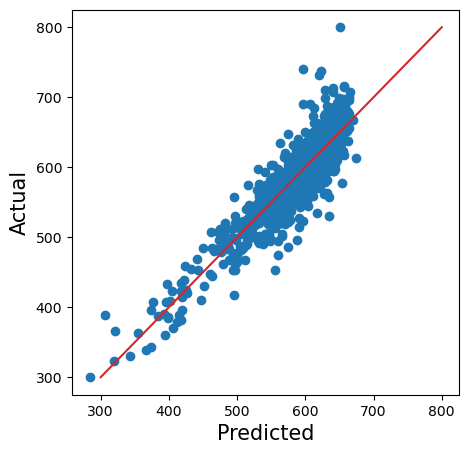

In [10]:
# Get model predictions
y_pred = model.predict(X)

# Plot predicted vs actual
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_pred,y)

# Plot y=x line
ax.plot([y.min(), y.max()], [y.min(), y.max()], color='tab:red')

plt.xlabel('Predicted',size=15)
plt.ylabel('Actual', size=15)

## Correlation matrix

<Axes: >

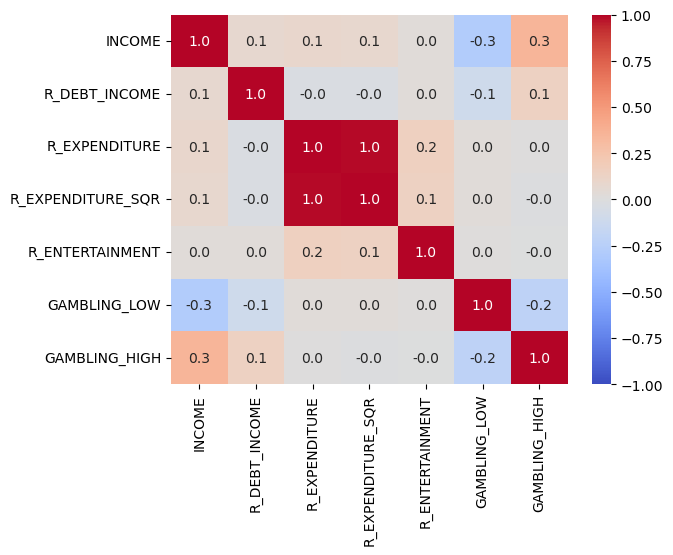

In [11]:
# Correlation matrix
corr_matrix = X.drop('const',axis=1).corr()
sns.heatmap(corr_matrix, cmap="coolwarm", fmt=".1f", vmin=-1, vmax=1,annot=True)

## Feature importance (absolute t-statistic)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'INCOME'),
  Text(1, 0, 'R_DEBT_INCOME'),
  Text(2, 0, 'R_EXPENDITURE'),
  Text(3, 0, 'R_EXPENDITURE_SQR'),
  Text(4, 0, 'R_ENTERTAINMENT'),
  Text(5, 0, 'GAMBLING_LOW'),
  Text(6, 0, 'GAMBLING_HIGH')])

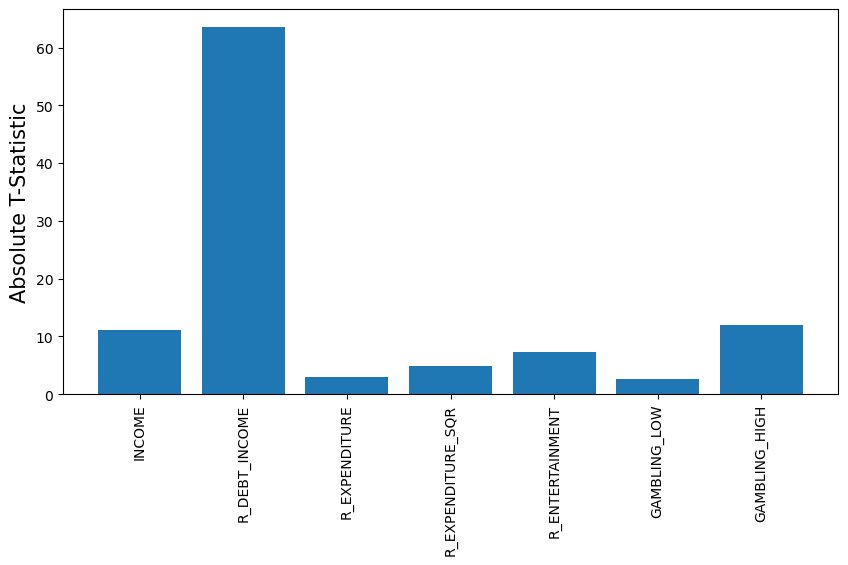

In [12]:
# Get the absolute values of the t-statistics from the model
t_statistic = model.tvalues[1:] # exclude the constant
abs_t_statistic = abs(t_statistic)

# Create a bar plot for feature importance
plt.figure(figsize=(10, 5))
plt.bar(X.columns[1:], abs_t_statistic)  

plt.ylabel('Absolute T-Statistic',size=15)
plt.xticks(rotation=90)

## T-statistic

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'INCOME'),
  Text(1, 0, 'R_DEBT_INCOME'),
  Text(2, 0, 'R_EXPENDITURE'),
  Text(3, 0, 'R_EXPENDITURE_SQR'),
  Text(4, 0, 'R_ENTERTAINMENT'),
  Text(5, 0, 'GAMBLING_LOW'),
  Text(6, 0, 'GAMBLING_HIGH')])

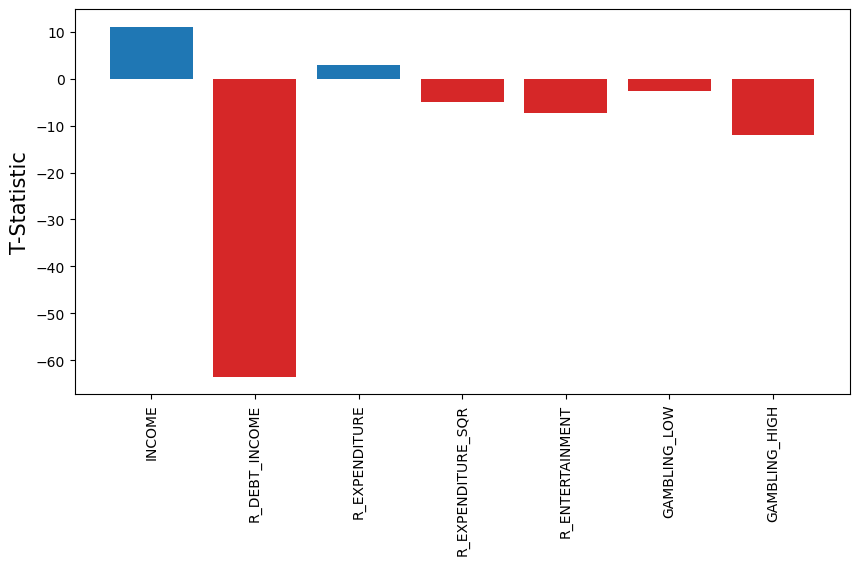

In [13]:
# Get bar colors based on the sign of the t-statistics
colors = ['tab:red' if t < 0 else 'tab:blue' for t in t_statistic]

plt.figure(figsize=(10, 5))
plt.bar(X.columns[1:], t_statistic, color=colors)

plt.ylabel('T-Statistic', size=15)
plt.xticks(rotation=90)

## Weight plot

Text(0.5, 0, 'Coefficient (Weight)')

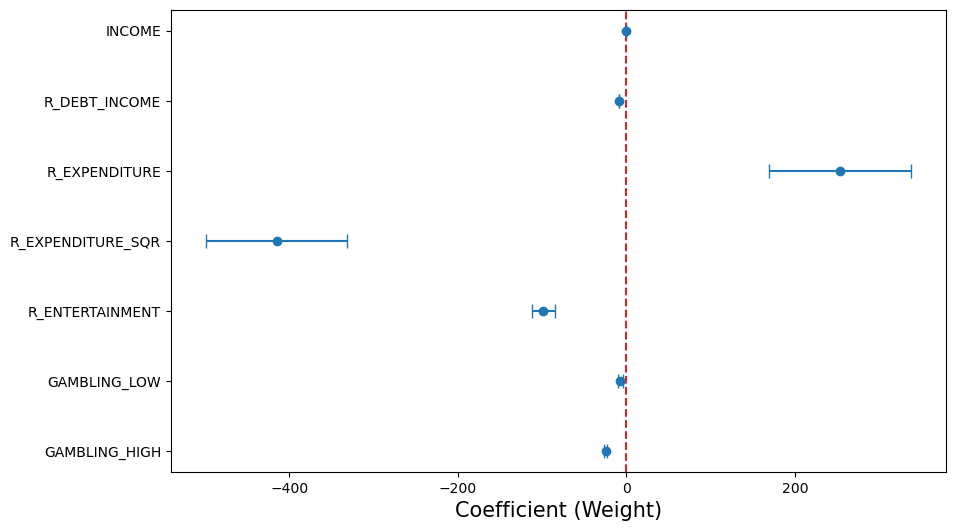

In [14]:
# Get coefficients and standard errors
coefficients = model.params[1:][::-1]
se = model.bse[1:][::-1]
features = X.columns[1:][::-1]

plt.figure(figsize=(10, 6))

# Plot vertical dotted line at x=0
plt.axvline(x=0, color='tab:red', linestyle='--')

# Plot the coefficients and error bars
plt.errorbar(coefficients, 
             features, 
             xerr=se, 
             fmt='o', 
             capsize=5)

plt.xlabel('Coefficient (Weight)', size=15)


In [15]:
scaler = StandardScaler()

# Scale the features
X_scaled = scaler.fit_transform(X.drop(columns='const'))
X_scaled = pd.DataFrame(X_scaled, columns=X.columns[1:])
X_scaled = sm.add_constant(X_scaled)

# Fit a linear regression model with scaled features
model_scaled = sm.OLS(y, X_scaled).fit()

# Output the summary of the model
print(model_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:           CREDIT_SCORE   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     672.1
Date:                Sat, 23 Nov 2024   Prob (F-statistic):               0.00
Time:                        20:40:10   Log-Likelihood:                -4694.1
No. Observations:                1000   AIC:                             9404.
Df Residuals:                     992   BIC:                             9444.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               586.7120      0.84

Text(0.5, 0, 'Coefficient (Weight)')

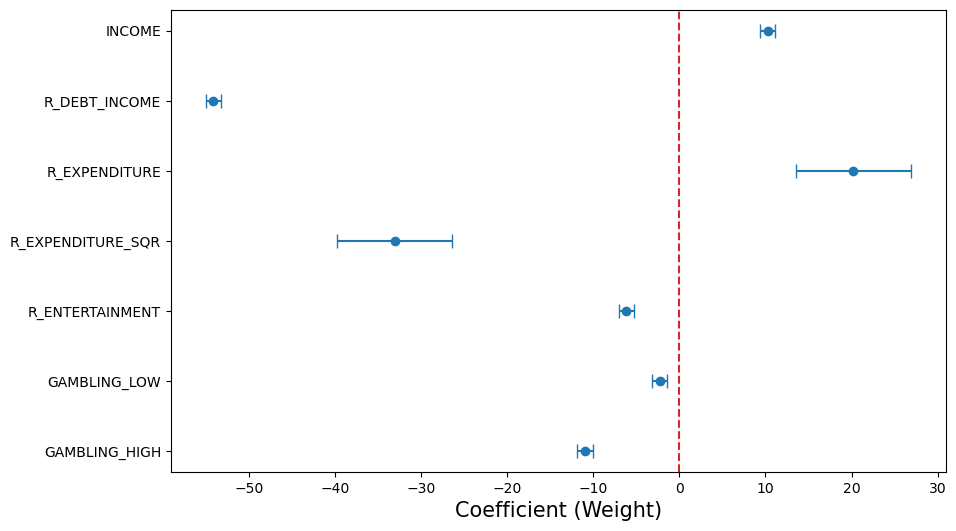

In [16]:
# Get coefficients and standard errors
coefficients = model_scaled.params[1:][::-1]
se = model_scaled.bse[1:][::-1]
features = X_scaled.columns[1:][::-1]

# Create a weight plot with scaled features
plt.figure(figsize=(10, 6))
plt.axvline(x=0, color='tab:red', linestyle='--')
plt.errorbar(coefficients, 
             features, 
             xerr=se, 
             fmt='o', 
             capsize=5)
plt.xlabel('Coefficient (Weight)', size=15)

## Effect plot

Text(0.5, 0, 'Effect on Credit Score')

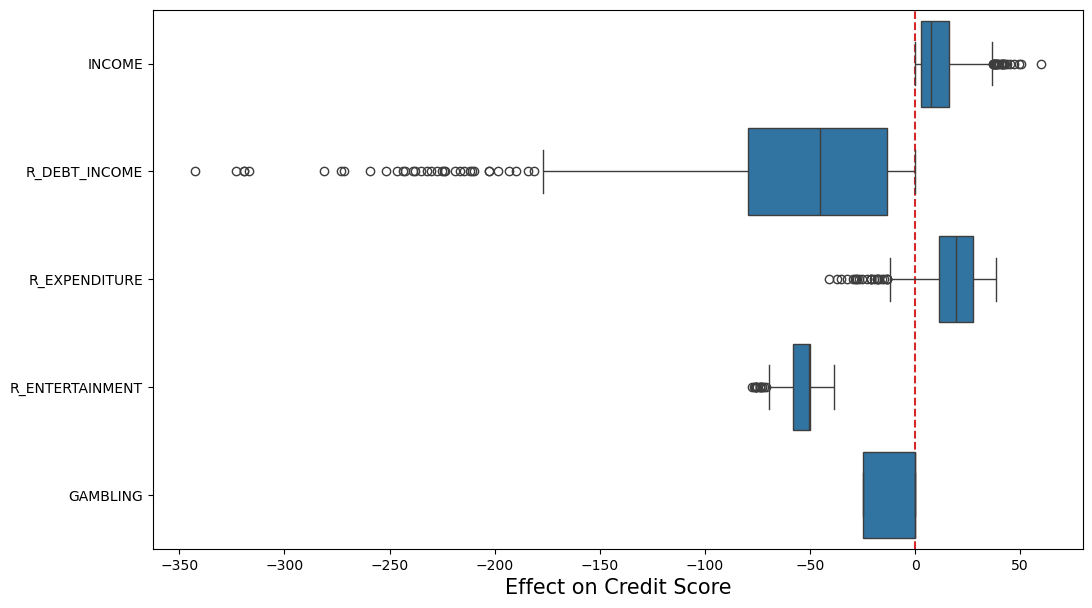

In [17]:
# Calculate the feature effects 
feature_effects = X * model.params

# Combine feature effects for related features
feature_effects['R_EXPENDITURE'] = feature_effects['R_EXPENDITURE'] + feature_effects['R_EXPENDITURE_SQR']
feature_effects['GAMBLING'] = feature_effects['GAMBLING_LOW']+feature_effects['GAMBLING_HIGH']
feature_effects.drop(['const','R_EXPENDITURE_SQR','GAMBLING_LOW','GAMBLING_HIGH'],axis=1,inplace=True)

# Create effect plots using boxplots
plt.figure(figsize=(12, 7))
plt.axvline(x=0, color='tab:red', linestyle='--')
sns.boxplot(data=feature_effects, orient="h", color="tab:Blue")
plt.xlabel("Effect on Credit Score", size=15)

Text(0.5, 0, 'Effect on Credit Score')

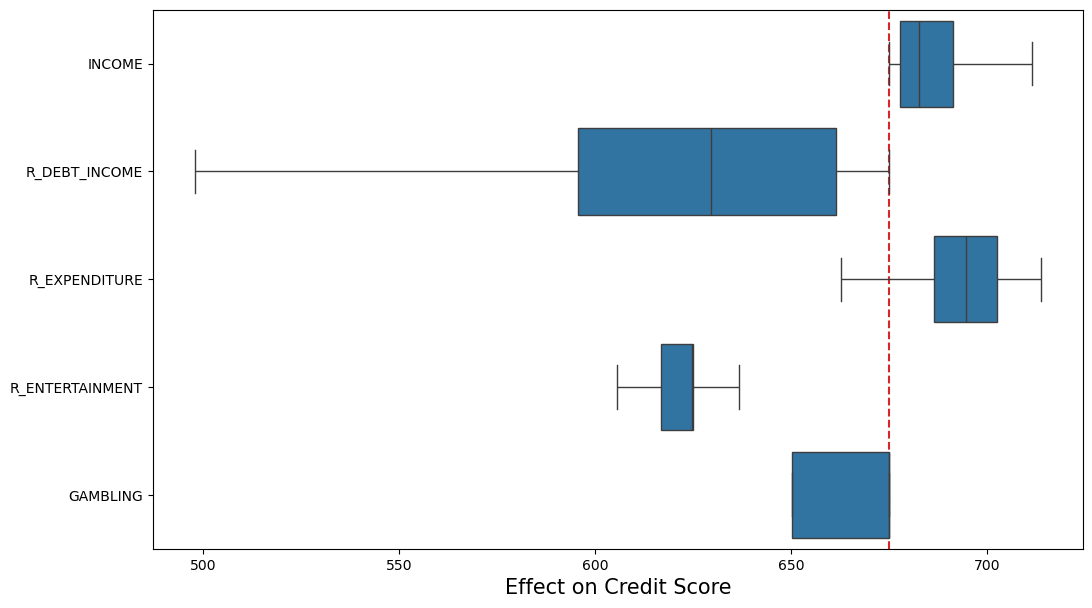

In [28]:
# Calculate the feature effects
feature_effects = X * model.params
const = feature_effects['const'][0] 

# Combine feature effects for related features
feature_effects['R_EXPENDITURE'] = feature_effects['R_EXPENDITURE'] + feature_effects['R_EXPENDITURE_SQR']
feature_effects['GAMBLING'] = feature_effects['GAMBLING_LOW']+feature_effects['GAMBLING_HIGH']
feature_effects.drop(['const','R_EXPENDITURE_SQR','GAMBLING_LOW','GAMBLING_HIGH'],axis=1,inplace=True)

# Add the constant to the feature effects
feature_effects = feature_effects + const

# Create effect plots using boxplots
plt.figure(figsize=(12, 7))
plt.axvline(x=const, color='tab:red', linestyle='--')
sns.boxplot(data=feature_effects, orient="h", color="tab:Blue", showfliers=False)
plt.xlabel("Effect on Credit Score", size=15)

## Mean effect plot 

Text(0.5, 0, 'Mean Effect on Credit Score')

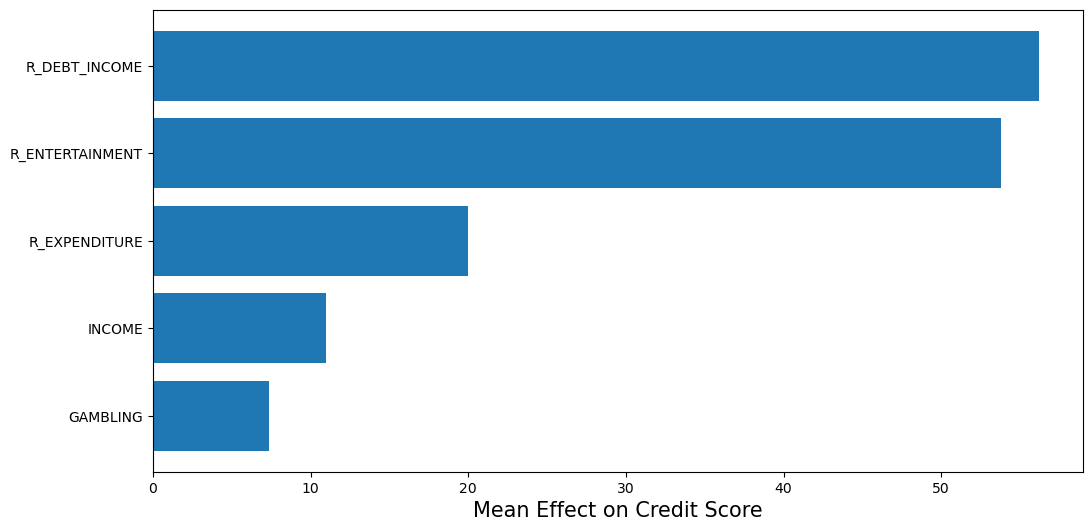

In [20]:
# Calculate the feature effects 
feature_effects = X * model.params

# Combine feature effects for related features
feature_effects['R_EXPENDITURE'] = feature_effects['R_EXPENDITURE'] + feature_effects['R_EXPENDITURE_SQR']
feature_effects['GAMBLING'] = feature_effects['GAMBLING_LOW']+feature_effects['GAMBLING_HIGH']
feature_effects.drop(['const','R_EXPENDITURE_SQR','GAMBLING_LOW','GAMBLING_HIGH'],axis=1,inplace=True)

# Calculate the absolute values of the feature effects
feature_effects = abs(feature_effects)
mean_effects = feature_effects.mean(axis=0)

# Sort by mean effect
mean_effects.sort_values(inplace=True)

# Create a bar plot for feature importance
plt.figure(figsize=(12, 6))
plt.barh(mean_effects.index, mean_effects)
plt.xlabel('Mean Effect on Credit Score', size=15)

## Effect trend plot

Text(0, 0.5, 'Effect on Credit Score')

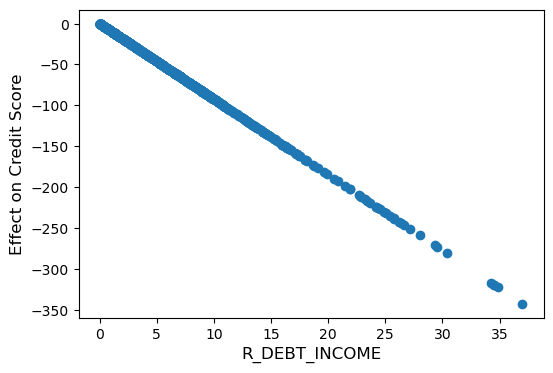

In [21]:
# Calculate the feature effects 
feature_effects = X * model.params

# Plot effect of R_DEPT_INCOME
plt.figure(figsize=(6, 4))
plt.scatter(X['R_DEBT_INCOME'], feature_effects['R_DEBT_INCOME'])

plt.xlabel('R_DEBT_INCOME', size=12)
plt.ylabel('Effect on Credit Score', size=12)

# Save figure
# utils.save_fig("LM4_trend_effect_plot")

## Individual effect plot

444
feature_effect: 
         INCOME  R_DEBT_INCOME  R_EXPENDITURE  R_ENTERTAINMENT    GAMBLING
0    677.952507     526.857982     682.306512       625.090780  650.131214
1    681.907541     637.088989     712.415115       625.317209  674.954489
2    677.740558     514.825141     684.520723       614.133562  650.131214
3    682.222851     602.757442     698.066140       624.805282  650.131214
4    688.469045     526.857982     703.575444       624.253975  650.131214
..          ...            ...            ...              ...         ...
995  704.592414     520.126070     694.550284       625.356588  650.131214
996  682.290167     597.539817     707.595212       612.154765  674.954489
997  674.954489     599.157771     634.160753       614.281233  674.954489
998  678.199601     519.659566     664.187600       624.696989  674.954489
999  678.943496     665.698458     701.747072       624.982487  674.954489

[1000 rows x 5 columns]
feature_effect: 
         INCOME  R_DEBT_INCOME  R_EXP

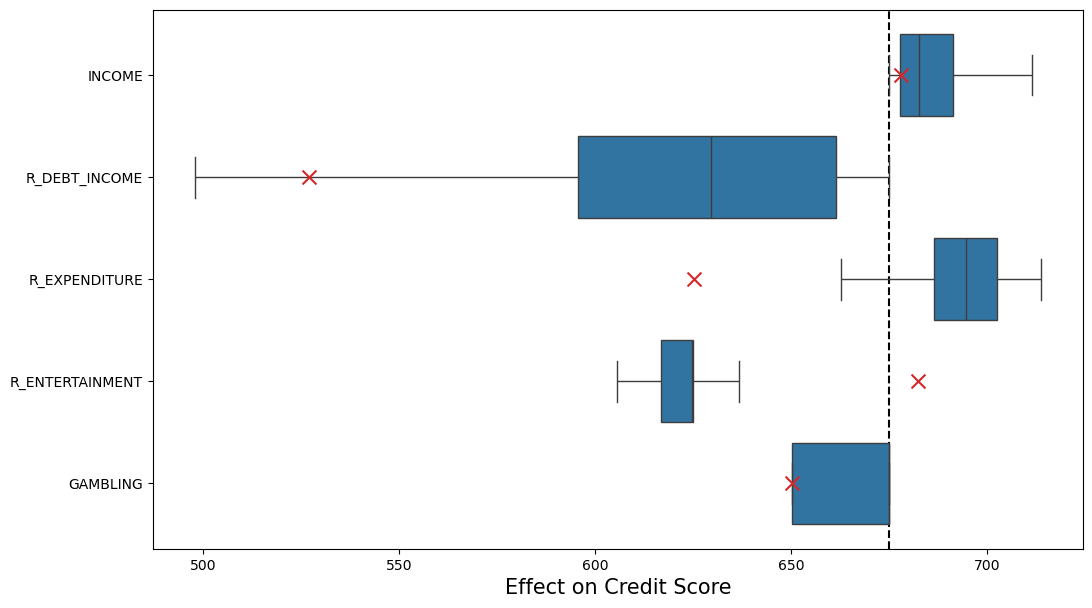

In [29]:
# Create effect plots using boxplots
plt.figure(figsize=(12, 7))
plt.axvline(x=const, color='black', linestyle='--')
sns.boxplot(data=feature_effects, orient="h", color="tab:Blue", showfliers=False)
plt.xlabel("Effect on Credit Score", size=15)

idx = 0  # You can change this to any valid index in your dataset
ind_feature_effect = X.iloc[idx] * model.params[1:]
print(y[idx])

# Combine feature effects for related features
ind_feature_effect['R_EXPENDITURE'] = ind_feature_effect['R_EXPENDITURE'] + ind_feature_effect['R_EXPENDITURE_SQR']
ind_feature_effect['GAMBLING'] = ind_feature_effect['GAMBLING_LOW']+ind_feature_effect['GAMBLING_HIGH']
ind_feature_effect.drop(['const','R_EXPENDITURE_SQR','GAMBLING_LOW','GAMBLING_HIGH'],axis=0,inplace=True)

print(f'feature_effect: \n{feature_effects}')

# Add the constant to the feature effects
ind_feature_effect = ind_feature_effect + const

print(f'feature_effect: \n{feature_effects}')

for i, feature in enumerate(ind_feature_effect):
    plt.scatter(feature, i, c='tab:red', marker='x', s=100, zorder=10)

/var/folders/h4/7cr1cmpn7v5b3x20_9wz8m740000gn/T/ipykernel_84135/2311391000.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X['R_DEBT_INCOME'], kde=False, bins=20, color='tab:blue')


Text(0, 0.5, 'Frequency')

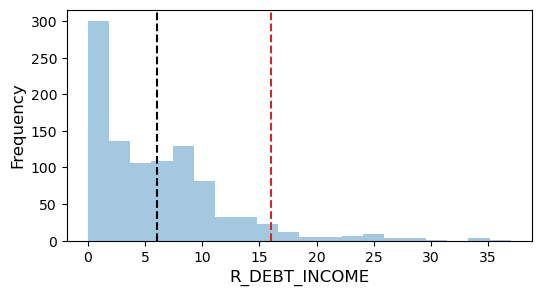

In [26]:
# Plot distribution of R_DEBT_INCOME
plt.figure(figsize=(6, 3))
sns.distplot(X['R_DEBT_INCOME'], kde=False, bins=20, color='tab:blue')

# add a vertical line for value of R_DEBT_INCOME for the selected individual
idx = 0
plt.axvline(x=X['R_DEBT_INCOME'][idx], color='tab:red', linestyle='--')

# add a vertical line for the mean value of R_DEBT_INCOME
plt.axvline(x=X['R_DEBT_INCOME'].mean(), color='black', linestyle='--')

plt.xlabel('R_DEBT_INCOME', size=12)
plt.ylabel('Frequency', size=12)

# Save figure
# utils.save_fig("LM4_feature_distribution")

444
625


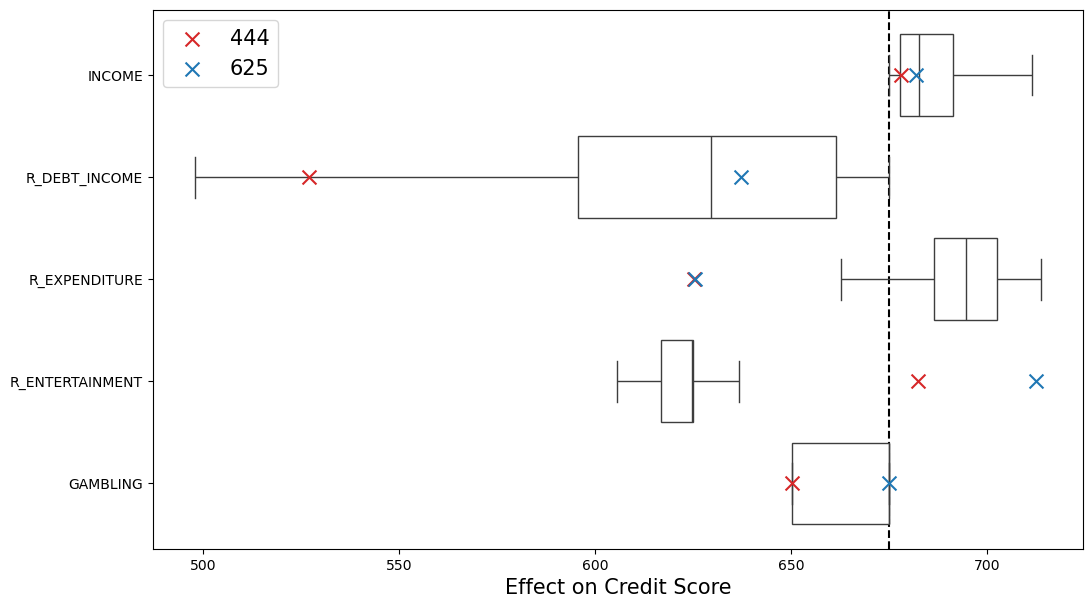

In [30]:
# Create effect plots using boxplots
plt.figure(figsize=(12, 7))
plt.axvline(x=const, color='black', linestyle='--')
sns.boxplot(data=feature_effects, orient="h", color="white", showfliers=False)
plt.xlabel("Effect on Credit Score", size=15)

colors = ['tab:red','tab:blue']
for idx in [0,1]:
    ind_feature_effect = X.iloc[idx] * model.params[1:]
    print(y[idx])

    # Combine feature effects for related features
    ind_feature_effect['R_EXPENDITURE'] = ind_feature_effect['R_EXPENDITURE'] + ind_feature_effect['R_EXPENDITURE_SQR']
    ind_feature_effect['GAMBLING'] = ind_feature_effect['GAMBLING_LOW']+ind_feature_effect['GAMBLING_HIGH']
    ind_feature_effect.drop(['const','R_EXPENDITURE_SQR','GAMBLING_LOW','GAMBLING_HIGH'],axis=0,inplace=True)

    # Add the constant to the feature effects
    ind_feature_effect = ind_feature_effect + const

    for i, feature in enumerate(ind_feature_effect):
        if i == 0:
            plt.scatter(feature, i, c=colors[idx], marker='x', s=100, zorder=10,label=y[idx])
        else:
            plt.scatter(feature, i, c=colors[idx], marker='x', s=100, zorder=10)

plt.legend(fontsize=15)

# Save figure
# utils.save_fig("LM4_individual_effect_plot_2")

## PDPs

In [28]:
# Fit a linear regression model with only debt-to-income ratio
model_income = sm.OLS(y, X[['const','R_DEBT_INCOME']]).fit()

print(model_income.summary())

                            OLS Regression Results                            
Dep. Variable:           CREDIT_SCORE   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     2782.
Date:                Sat, 23 Nov 2024   Prob (F-statistic):          7.17e-291
Time:                        19:45:31   Log-Likelihood:                -4902.2
No. Observations:                1000   AIC:                             9808.
Df Residuals:                     998   BIC:                             9818.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           643.1667      1.486    432.810

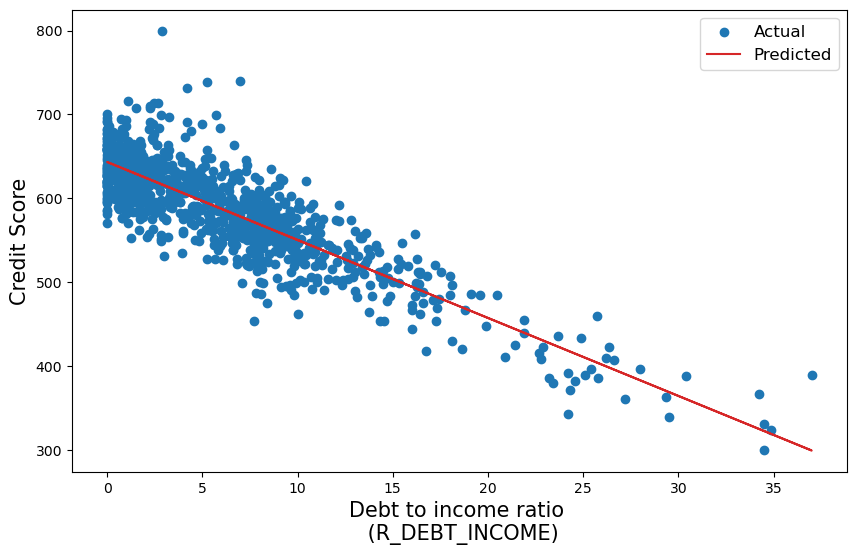

In [29]:
# Plot credit score vs income
plt.figure(figsize=(10, 6))
plt.scatter(X['R_DEBT_INCOME'], y,label='Actual')

# Plot the regression line
preds = model_income.predict(X[['const','R_DEBT_INCOME']])
plt.plot(X['R_DEBT_INCOME'],
        preds, 
        color='tab:red',
        label='Predicted')

plt.xlabel('Debt to income ratio \n (R_DEBT_INCOME)', size=15)
plt.ylabel('Credit Score', size=15)

plt.legend(fontsize=12)

# Save figure
# utils.save_fig("LM4_model_income")

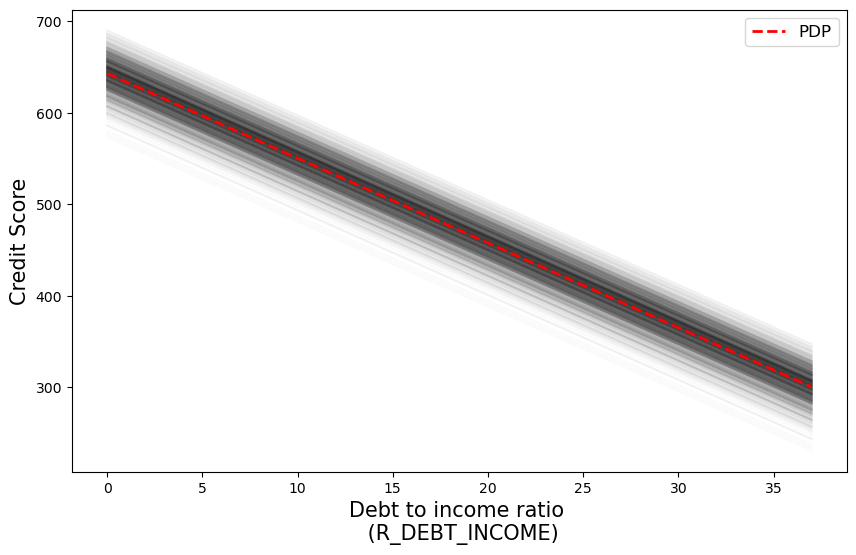

In [30]:
# Create a list of values for the feature
feature_values = np.linspace(X['R_DEBT_INCOME'].min(), X['R_DEBT_INCOME'].max(), 100)
X_pdp = X.copy()

plt.figure(figsize=(10, 6))

all_preds = []
for i,row in X_pdp.iterrows():

    preds = []
    for value in feature_values:

        # replace the value of the feature and get prediction
        row['R_DEBT_INCOME'] = value
        pred = model.predict(row.values)
        preds.append(pred)

    all_preds.append(preds)

    # plot individual prediction line
    plt.plot(feature_values, preds, color='black',alpha=0.02)

# plot average prediction line
average_preds = np.mean(all_preds,axis=0)
plt.plot(feature_values, average_preds, color='r',linewidth=2,label='PDP',linestyle='--')

plt.xlabel('Debt to income ratio \n (R_DEBT_INCOME)', size=15)
plt.ylabel('Credit Score', size=15)

plt.legend(fontsize=12)

# Save figure
# utils.save_fig("LM4_pdp_income")

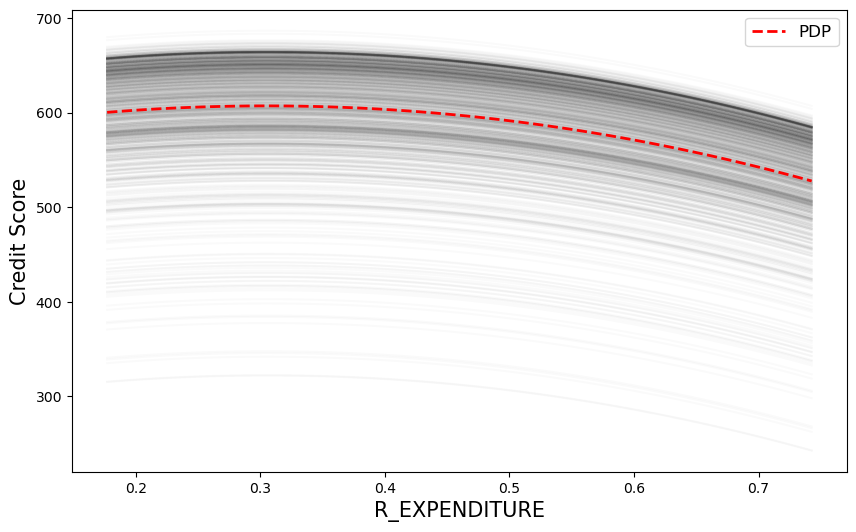

In [31]:
# Create a list of values for the feature
feature_values = np.linspace(X['R_EXPENDITURE'].min(), X['R_EXPENDITURE'].max(), 100)
X_pdp = X.copy()

plt.figure(figsize=(10, 6))

all_preds = []
for i,row in X_pdp.iterrows():

    preds = []
    for value in feature_values:

        # replace the value of the feature and get prediction
        row['R_EXPENDITURE'] = value
        row['R_EXPENDITURE_SQR'] = value**2
        pred = model.predict(row.values)
        preds.append(pred)
    
    all_preds.append(preds)

    # plot individual prediction line
    plt.plot(feature_values, preds, color='black',alpha=0.02)

# plot average prediction line
average_preds = np.mean(all_preds,axis=0)
plt.plot(feature_values, average_preds, color='r',linewidth=2,label='PDP',linestyle='--')

plt.xlabel('R_EXPENDITURE', size=15)
plt.ylabel('Credit Score', size=15)

plt.legend(fontsize=12)

# Save figure
# utils.save_fig("LM4_pdp_expediture")

## SHAP values

In [32]:
# Calculate SHAP values
explainer = shap.KernelExplainer(model.predict,X)
shap_values = explainer(X)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1000 [00:00<?, ?it/s]

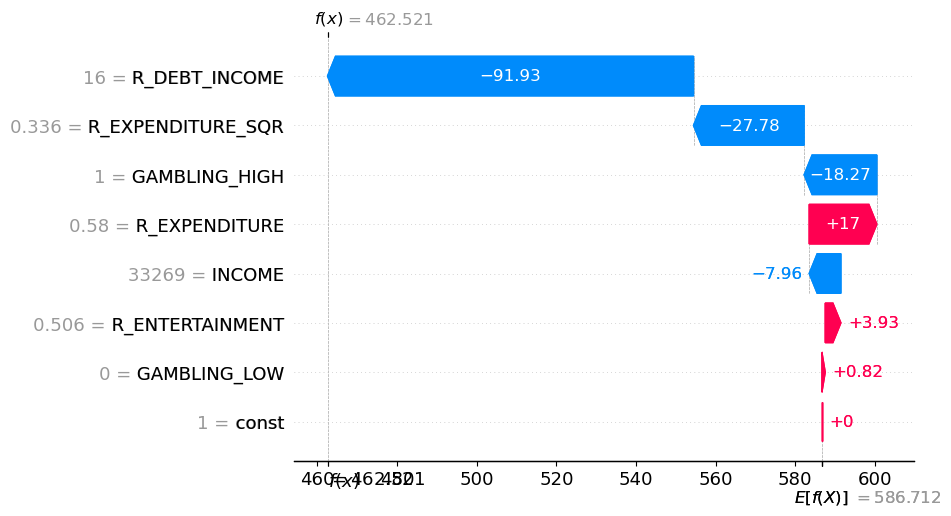

In [35]:
shap.plots.waterfall(shap_values[0], show=False)
plt.show()

# Save figure
# utils.save_fig("LM4_shap_waterfall")

In [36]:
preds = model.predict(X)

# calculate average prediction
print(np.mean(preds))

586.7119999999949


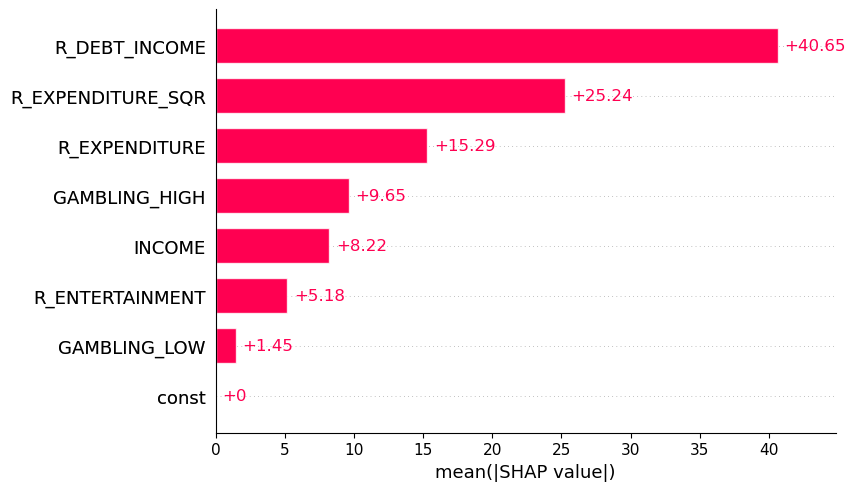

In [37]:
# SHAP bar plot
shap.plots.bar(shap_values)
plt.show()
# Save figure
# utils.save_fig("LM4_shap_bar")